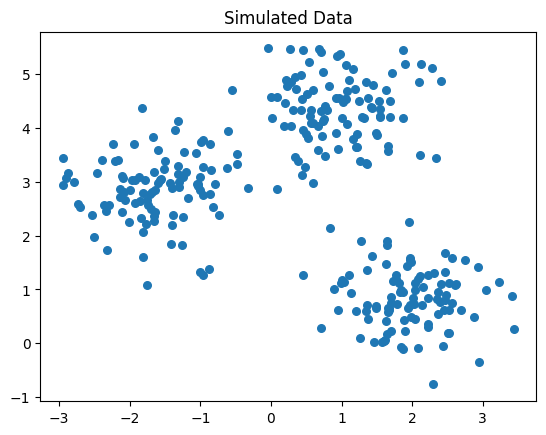

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Simulate data from 3 Gaussian clusters
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=30)
plt.title("Simulated Data")
plt.show()


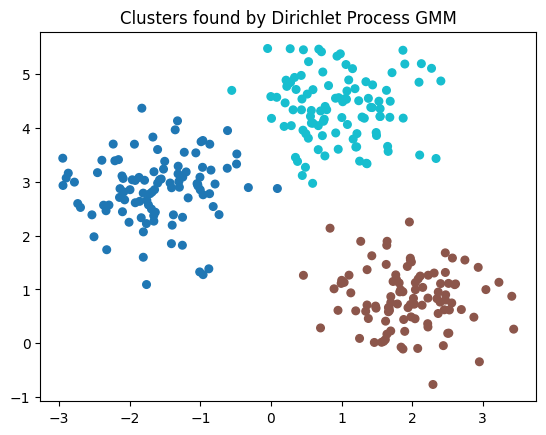

In [2]:
from sklearn.mixture import BayesianGaussianMixture

# Define the DP mixture model
dpgmm = BayesianGaussianMixture(
    n_components=10,  # Upper bound on the number of components
    covariance_type='full',
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=1e-2,  # Small value favors fewer components
    max_iter=1000,
    random_state=0
)

# Fit the model
dpgmm.fit(X)
labels = dpgmm.predict(X)

# Plot the clustering result
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=30)
plt.title("Clusters found by Dirichlet Process GMM")
plt.show()


Epoch 0: Loss = 6.9688
Epoch 500: Loss = 4.4357
Epoch 1000: Loss = 4.1739
Epoch 1500: Loss = 4.9303
Epoch 2000: Loss = 4.6526
Epoch 2500: Loss = 4.6587
Epoch 3000: Loss = 4.6157
Epoch 3500: Loss = 4.4739
Epoch 4000: Loss = 3.7444
Epoch 4500: Loss = 4.4222


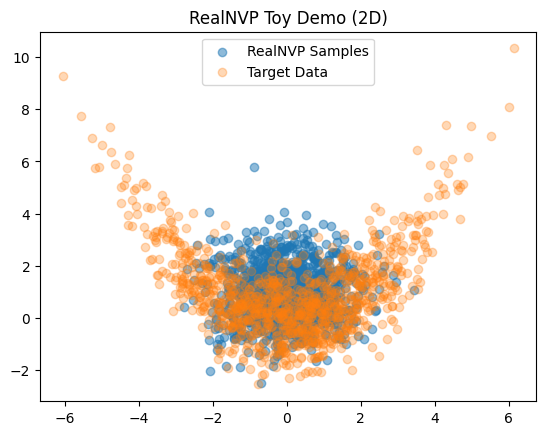

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# RealNVP Block
# -----------------------
class RealNVPBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.s = nn.Sequential(nn.Linear(dim // 2, 128), nn.ReLU(), nn.Linear(128, dim // 2))
        self.t = nn.Sequential(nn.Linear(dim // 2, 128), nn.ReLU(), nn.Linear(128, dim // 2))

    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        s = self.s(x1)
        t = self.t(x1)
        y1 = x1
        y2 = x2 * torch.exp(s) + t
        log_det_jacobian = s.sum(dim=1)
        return torch.cat([y1, y2], dim=1), log_det_jacobian

    def inverse(self, y):
        y1, y2 = y.chunk(2, dim=1)
        s = self.s(y1)
        t = self.t(y1)
        x1 = y1
        x2 = (y2 - t) * torch.exp(-s)
        return torch.cat([x1, x2], dim=1)

# -----------------------
# RealNVP Model
# -----------------------
class RealNVP(nn.Module):
    def __init__(self, dim, num_blocks):
        super().__init__()
        self.blocks = nn.ModuleList([RealNVPBlock(dim) for _ in range(num_blocks)])

    def forward(self, z):
        log_det = 0
        x = z
        for block in self.blocks:
            x, ldj = block(x)
            log_det += ldj
        return x, log_det

    def inverse(self, x):
        z = x
        for block in reversed(self.blocks):
            z = block.inverse(z)
        return z

# -----------------------
# Training on 2D target
# -----------------------
def sample_target_distribution(n):
    x = np.random.randn(n, 2)
    x[:, 0] *= 2
    x[:, 1] += x[:, 0] ** 2 * 0.25
    return torch.tensor(x, dtype=torch.float32)

# Settings
dim = 2
num_blocks = 6
model = RealNVP(dim, num_blocks)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(5000):
    z = torch.randn(256, dim)
    x_target = sample_target_distribution(256)
    x_transformed, log_det = model(z)
    loss = F.mse_loss(x_transformed, x_target) - log_det.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# Visualize learned samples
with torch.no_grad():
    z = torch.randn(1000, dim)
    x_sampled, _ = model(z)
    x_sampled = x_sampled.numpy()

plt.scatter(x_sampled[:, 0], x_sampled[:, 1], alpha=0.5, label='RealNVP Samples')
x_true = sample_target_distribution(1000).numpy()
plt.scatter(x_true[:, 0], x_true[:, 1], alpha=0.3, label='Target Data')
plt.legend()
plt.title("RealNVP Toy Demo (2D)")
plt.show()
